In [229]:
using CSV, DataFrames, Statistics, Random, Plots, JuMP, Gurobi, Distributions, Random, Metrics
using StatsBase: sample

#import sklearn functions 
using ScikitLearn
@sk_import linear_model: LogisticRegression
@sk_import linear_model: LinearRegression
@sk_import linear_model: Lasso
@sk_import metrics:accuracy_score;
@sk_import metrics:precision_score;
@sk_import metrics:recall_score;
@sk_import metrics:mean_squared_error;

include("utils.jl");

In [173]:
#todo change X_shifted that it is added later
mutable struct RegressionClass
    name::String
    X_full::DataFrame
    X_shifted::DataFrame
    y_full::Vector{Float64}
    y_shifted::Vector{Float64}
    covar_dist_type::String
    covar_parameters::Vector{Any}
    lambas_range::Vector{Float64}
    train_test_prop::Float64
    train_val_prop::Float64
    num_runs::Float64
end

### preprocess functions

In [196]:
function perform_covariate_shift(rc::RegressionClass, X_full_norm)
    pca_result = perform_pca(X_full_norm)
    m = median(pca_result)
    X_train, X_test = [], []
    y_train, y_test = [], []

    for i in 1:size(X_full_norm, 1)
        if pca_result[i, 1] >= m
            if rand() <= rc.covar_parameters[1]
                push!(X_train, X_full_norm[i, :])
                push!(y_train, rc.y_full[i])
            else
                push!(X_test, X_full_norm[i, :])
                push!(y_test, rc.y_full[i])
            end
        end
        
        if pca_result[i, 1] < m
            if rand() <= rc.covar_parameters[2]
                push!(X_train, X_full_norm[i, :])
                push!(y_train, rc.y_full[i])
            else
                push!(X_test, X_full_norm[i, :])
                push!(y_test, rc.y_full[i])
            end
        end
    end
    
    # reshape list of lists to be a matrix
    X_train_reshaped = zeros(length(X_train), size(X_full_norm, 2))
    X_test_reshaped = zeros(length(X_test), size(X_full_norm, 2))
    
    for i in 1:size(X_train, 1)
        X_train_reshaped[i, :] = X_train[i]
    end
    for i in 1:size(X_test, 1)
        X_test_reshaped[i, :] = X_test[i]
    end
    
    # TODO: improve
    # ensure train-test split proportions
    # println("Train size before sub-selecting: ", size(X_train, 1))
    # println("Test size before sub-selecting: ", size(X_test, 1))
    idx_train = randperm(size(X_train, 1))[1:Int(rc.covar_parameters[3])]
    idx_test = randperm(size(X_test, 1))[1:Int(rc.covar_parameters[4])]
    X_train_reshaped = X_train_reshaped[idx_train, :]
    X_test_reshaped = X_test_reshaped[idx_test, :]
    y_train = y_train[idx_train]
    y_test = y_test[idx_test]
    
    return (X_train_reshaped, y_train), (X_test_reshaped, y_test)
end

perform_covariate_shift (generic function with 3 methods)

In [198]:
function normalise_X_full(rc::RegressionClass)
    mean_vals = mean(Matrix(rc.X_full), dims=1)
    std_vals = std(Matrix(rc.X_full), dims=1)
    X_full_norm = (Matrix(rc.X_full) .-mean_vals) ./ std_vals;
    return X_full_norm 
    
end

normalise_X_full (generic function with 1 method)

In [199]:
# function generate_covariate_shift(rc::RegressionClass, seed = 123)
#     #set a seed for distribution
#     Random.seed!(seed)

#     if rc.covar_dist_type == "Normal"
#         col_means = mean(Matrix(rc.X), dims=1)
#         col_vars = var(Matrix(rc.X), dims = 1)

#         random_values = zeros(size(rc.X))

#         for col_index in 1:size(rc.X, 2)
#             col_mean = col_means[col_index]
#             col_var = col_vars[col_index]
#             col_shift = rand(Normal(col_mean + rc.covar_parameters[1] , sqrt(col_var) * rc.covar_parameters[2]), (size(rc.X, 1), 1))
#             random_values[:, col_index] = col_shift
#         end

#         X_shifted = Matrix(rc.X) .+ random_values;
#         rc.X_shifted = DataFrame(X_shifted, Symbol.(names(rc.X)))
#     end
# end

In [200]:
function train_test_split(rc::RegressionClass, random_seed)
    
    Random.seed!(random_seed)

    num_indices = round(Int, rc.train_test_prop * length(rc.y_full))
    train_indices = sample(1:length(rc.y_full), num_indices, replace=false)
    test_indices = setdiff(1:length(rc.y_full), train_indices)
    
    X_train, y_train = Matrix(rc.X_full)[train_indices, :], rc.y_full[train_indices]
    X_test, y_test = Matrix(rc.X_shifted)[test_indices, :], rc.y_shifted[test_indices]
    
    return (X_train, y_train), (X_test, y_test)
end

train_test_split (generic function with 1 method)

### Stable Regression

In [212]:
function train_val_opt_split(rc::RegressionClass, X_train_full, y_train_full, beta_opt, weights = "nothing")

    residuals = y_train_full - X_train_full * beta_opt

    if weights == "nothing"
        sorted_indices = sortperm(abs.(residuals), rev=true)
    else 
        residuals_weights = [residuals[i] * weights[i] for i in 1:length(weights)]
        sorted_indices = sortperm(abs.(residuals_weights), rev=true)
    end

    num_train_points = round(Int, rc.train_val_prop * length(sorted_indices))

    train_indices = sorted_indices[1:num_train_points]

    val_indices = setdiff(1:length(y_train_full), train_indices)

    X_train = X_train_full[train_indices, :] 
    y_train = y_train_full[train_indices]

    X_val = X_train_full[val_indices, :]
    y_val = y_train_full[val_indices]

    return X_train, y_train, X_val, y_val
end


train_val_opt_split (generic function with 2 methods)

In [213]:
#todo: could change X, y to X_train, y_train
function get_optimized_split(rc::RegressionClass, X, y, lambda, weights="nothing")
    # to do: should n be an attribute
    n, p = size(X)
    k = round(Int, n * rc.train_val_prop)
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, theta)
    @variable(model, u[1:n] >= 0)
    @variable(model, beta[1:p])
    @variable(model, w[1:p])
    @objective(model, Min, k * theta + sum(u) + lambda * sum(w))
    
    for i in 1:p
        @constraint(model, w[i] >= beta[i])
        @constraint(model, w[i] >= -beta[i])
    end 
    
    for i in 1:n
        if weights == "nothing"
            @constraint(model, theta + u[i] >= y[i] - sum(X[i, :].*beta))
            @constraint(model, theta + u[i] >= -(y[i] - sum(X[i, :].*beta)))
        else 
            @constraint(model, theta + u[i] >=  weights[i] * (y[i] - sum(X[i, :].*beta)))
            @constraint(model, theta + u[i] >= - weights[i] * (y[i] - sum(X[i, :].*beta)))
        end 
    end
    
    
    optimize!(model)
    return value(theta), value.(u), value.(beta), value.(w) 
end

get_optimized_split (generic function with 2 methods)

In [214]:
function get_optimized_split_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf
    
    for lambda in rc.lambas_range
        # Get optimized split
        _, _, betas, _ = get_optimized_split(rc, X_full_train, y_full_train, lambda, weights)
        X_train, y_train, X_val, y_val = train_val_opt_split(rc, X_full_train, y_full_train, betas, weights)
        
        # Predict on validation set
        y_pred_val =  X_val * betas
        val_mse_i = mse(y_val, y_pred_val)
        
        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = betas
        end
    end

    #get mse on test set for best performing model 
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end

    return best_model, mse_test_mse
end

get_optimized_split_test_score (generic function with 3 methods)

In [219]:
function get_random_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, seed_value, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf

    (X_train, y_train), (X_val, y_val) = 
        IAI.split_data(:regression, X_full_train, y_full_train, train_proportion=rc.train_val_prop, seed=seed_value)

    for lambda in rc.lambas_range
        
        beta_star = LassoRegression(X_train, y_train, lambda, weights)

        y_pred_val = X_val * beta_star
        val_mse_i = mse(y_val, y_pred_val)

        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = beta_star
        end
    end

    #get test mse score on best performing model
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end
   
    return best_model, mse_test_mse
end


get_random_test_score (generic function with 3 methods)

In [216]:
#todo: deal with prints (false)
#todo: add what is returned to instance 
function repeat_four_methods(rc::RegressionClass)

    random_mse_test_scores, random_weights_mse_test_scores = [], []
    optim_mse_test_scores, optim_weights_mse_test_scores = [], []

    rand_betas, rand_weights_betas = [], []
    opt_betas, opt_weights_betas = [], []

    for random_seed in 1:rc.num_runs
        random_seed = Int(random_seed) #need to be int 

        if rc.covar_dist_type == "PCA"
            #pca shift on real dataset 
            X_full_norm = normalise_X_full(rc)
            (X_train, y_train), (X_test, y_test) = perform_covariate_shift(rc, X_full_norm)
        else
            # synthetic data (shift has already been performed when creating the dataset)
            (X_train, y_train), (X_test, y_test) = train_test_split(rc, random_seed)
        end

        X_train_norm, X_test_norm = normalize_data(X_train, X_test)
        X_train_norm, X_test_norm = add_intercept(X_train_norm), add_intercept(X_test_norm)

        weights = get_weights(X_train_norm, X_test_norm, false)

        if random_seed % 10 == 0
            println(random_seed)
        end

        # println("Starting Randomization")
        rand_beta, random_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, random_seed, "nothing", false)
        push!(random_mse_test_scores, random_mse_test_score)
        push!(rand_betas, rand_beta)
        
        
        # println("Starting Randomization with covariate weights")
        rand_weights_beta, random_weights_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, random_seed, weights, false)
        push!(random_weights_mse_test_scores, random_weights_mse_test_score)
        push!(rand_weights_betas, rand_weights_beta)
        
        # println("Starting Optimization")
        opt_beta, optim_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, "nothing", false)
        push!(optim_mse_test_scores, optim_mse_test_score)
        push!(opt_betas, opt_beta)

        
        # println("Starting Optimization with covariate weights")
        opt_weights_beta, optim_weights_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, weights, false)
        push!(optim_weights_mse_test_scores, optim_weights_mse_test_score)
        push!(opt_weights_betas, opt_weights_beta)
    end 
    
    return (rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores)
end


repeat_four_methods (generic function with 1 method)

## Test with DATA


In [217]:
#hyperparameters
num_runs = 100
train_test_prop = 0.9
train_val_prop = 0.7
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1];

### Test with synthetic data

- https://jmlr.org/papers/volume8/sugiyama07a/sugiyama07a.pdf

- page 7

In [230]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "1", 123)

synthetic_instance_1 = RegressionClass(
    "synthetic_1",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    [0,0],
    lambdas,
    train_test_prop,
    train_val_prop,
    100);

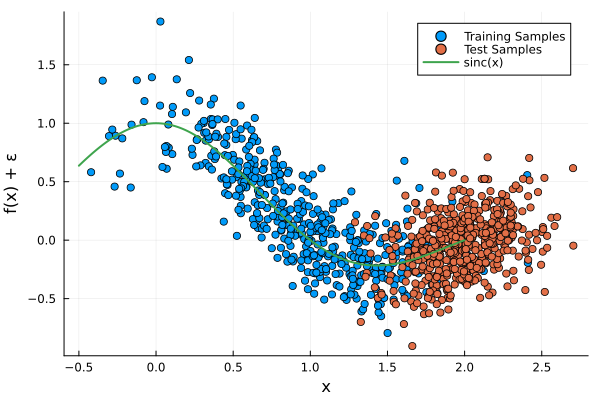

In [231]:
plot_synthetic(X_full, y_full, X_shifted, y_shifted, "1")

In [232]:
(rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_1);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial

In [233]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: 2.067452989839659
% improvement in mse with weight: 76.19461866496633


In [234]:
calculate_percentage_improvement(random_weights_mse_test_scores, random_mse_test_scores)


-49.016438793408064

In [ ]:
mean_random_betas = mean(rand_betas, dims = 1)
mean_random_weights_betas = mean(rand_weights_betas, dims = 1)
mean_opt_betas = mean(opt_betas, dims = 1)
mean_opt_weights_betas = mean(opt_weights_betas, dims = 1);

In [ ]:
f_1(x) = sinc(x)
f_ow(x) =  mean_opt_weights_betas[1] +  mean_opt_weights_betas[2]* x
f_rw(x) =  mean_random_weights_betas[1] +  mean_random_weights_betas[2]* x
f_r(x) =  mean_random_betas[1] +  mean_random_betas[2]* x
f_o(x) =  mean_opt_betas[1] +  mean_opt_betas[2]* x

plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-0.5, stop=2, length=500)
plot!(x_values, f_1.(x_values), label="sinc(x)", linewidth=2, size=(800, 600))
plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_1.png")

display(plot_obj)

### synthetic data 2

In [224]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "2", 123)

synthetic_instance_2 = RegressionClass(
    "synthetic_2",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    lambdas,
    [0],
    train_test_prop,
    train_val_prop,
    100);

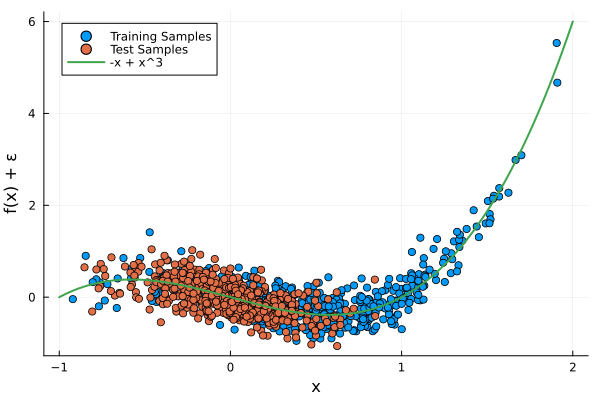

In [225]:
plot_synthetic(X_full, y_full, X_shifted, y_shifted, "2")

In [226]:
(rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_2);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
hello
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNNTER
ENNNNNNN

In [227]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: -2.4798303868388842
% improvement in mse with weight: 29.373044202316382


In [140]:
mean_random_betas = mean(rand_betas, dims = 1)
mean_random_weights_betas = mean(rand_weights_betas, dims = 1)
mean_opt_betas = mean(opt_betas, dims = 1)
mean_opt_weights_betas = mean(opt_weights_betas, dims = 1);

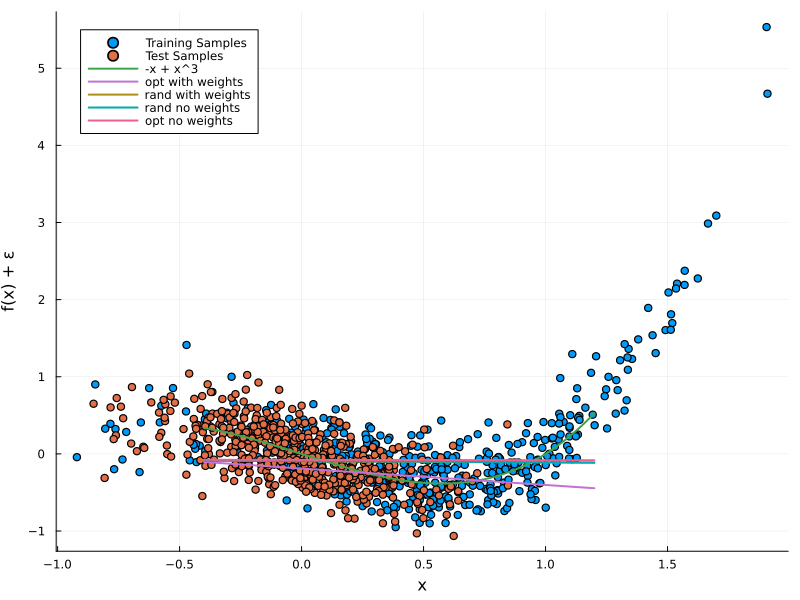

In [132]:
f_2(x) = -x + x^3 
f_ow(x) =  mean_opt_weights_betas[1][1] +  mean_opt_weights_betas[1][2]* x
f_rw(x) =  mean_random_weights_betas[1][1] +  mean_random_weights_betas[1][2]* x
f_r(x) =  mean_random_betas[1][1] +  mean_random_betas[1][2]* x
f_o(x) =  mean_opt_betas[1][1] +  mean_opt_betas[1][2]* x


plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-0.4, stop=1.2, length=500)

# Modify the size attribute to make the plot bigger
plot!(x_values, f_2.(x_values), label="-x + x^3", linewidth=2, size=(800, 600))
plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_2.png")

display(plot_obj)


## Real Data

In [121]:
X_full_df, y_full = get_concrete_data()

concrete_instance = RegressionClass(
    "concrete",
    X_full_df,
    X_full_df,
    y_full,
    y_full,
    "PCA",
    [0.1,0.9, 405, 45],
    lambdas,
    train_test_prop,
    train_val_prop,
    1000);

In [122]:
(_, _, _, _), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores) = repeat_four_methods(concrete_instance);

Train size before sub-selecting: 522
Test size before sub-selecting: 508
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Use

Excessive output truncated after 524496 bytes.

In [124]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: 1.5652025635162041
% improvement in mse with weight: 57.63222562132412
